In [1]:
from datasets import load_dataset
import sentencepiece as spm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import nltk
from nltk.tokenize import sent_tokenize
import random
from datasets import concatenate_datasets
from datasets import Dataset
import requests
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
from datasets import load_dataset, concatenate_datasets
import jieba

## Function For Scraping

In [2]:
#This function is used for finding data needed on the internet for neutral_sentiment

def neutral_sentiment_function(urls):
    articles_content = []
    for url in urls: #fill articles_content with content from url's
        response = requests.get(url)
        # Adjust encoding based on the site's specific encoding
        response.encoding = 'UTF-8'
        soup = BeautifulSoup(response.text, "html.parser")
        # Adjust the selection based on the content structure of the site
        article_content = soup.find("div", class_="mw-page-container-inner") 
        if article_content:
            articles_content.append(article_content.get_text())#creating a data frame of sentences
   # nltk.download('punkt')
    all_sentences = []
    for content in articles_content:
        sentences = sent_tokenize(content)
        all_sentences.extend(sentences)
    df = pd.DataFrame(all_sentences, columns=['text'])
    df.reset_index(drop=True, inplace=True)
    print(df.head())
    #df['data'] = df['text'].apply(lambda x: {'label': 2, 'text': x}) #every neutral will be referenced with a 2
    #neutral_data = df['data'].tolist()
    return df

## Function For Combining

In [3]:
def combine_data(df,sentiment_type,train_dataset,test_dataset):
    sentiment_number = 0
    if sentiment_type == 'positive':
        sentiment_number = 1
    elif sentiment_type == 'negative':
        sentiment_number = 0
    elif sentiment_type == 'neutral':
        sentiment_number = 2
    print(df.head())
    df['data'] = df['text'].apply(lambda x: {'label': sentiment_number, 'text': x}) #every neutral will be referenced with a 2
    #print("After applying transformation: \n", df.head())
    added_data = df['data'].tolist()
    #print("List of dictionaries (added_data): \n", added_data[:5])
    total_length = len(added_data)
    #print("Total length of added_data: ", total_length)
    split_index = int(total_length * 0.75)
    added_training_data = added_data[:split_index]
    data_dict = {key: [dic[key] for dic in added_training_data] for key in added_training_data[0]}
    #print("Data dictionary ready for Dataset conversion: \n", list(data_dict.keys())) 
    added_training_dataset = Dataset.from_dict(data_dict)
    #print("Added training dataset: \n", added_training_dataset)
    combined_training_dataset = concatenate_datasets([train_dataset,added_training_dataset])
    train_dataset = combined_training_dataset.shuffle(seed = 42)

    added_testing_data = added_data[split_index:]#:split_index+30]######
    data_dict = {key: [dic[key] for dic in added_testing_data] for key in added_testing_data[0]}
    added_testing_dataset = Dataset.from_dict(data_dict)
    combined_testing_dataset = concatenate_datasets([test_dataset,added_testing_dataset])
   
    test_dataset = combined_testing_dataset.shuffle(seed=42)
    #print(test_dataset[:])
    return train_dataset, test_dataset

## Loading the Datasets

In [4]:
'''# Define the URL of the XML data
xml_url = "https://alt.qcri.org/semeval2016/task5/data/uploads/trial-data/mobilephones_trial_chinese.xml"

# Fetch the XML content from the URL
response = requests.get(xml_url)
xml_data = response.content

# Parse the XML data
root = ET.fromstring(xml_data)

# Initialize a big dictionary with keys for each attribute and empty lists as values
big_dict = {'label': [], 'text': []}

# Iterate through each review in the XML data
for review in root.findall('Review'):
    for sentence in review.find('sentences').findall('sentence'):
        # Extract the text of the sentence
        sentence_text = sentence.find('text').text
        
        # Initialize the label as 2 (neutral) by default
        sentence_label = 2  # Neutral
        
        # Check if there is an Opinion tag and extract polarity as label
        opinion = sentence.find('Opinions/Opinion')
        if opinion is not None:
            if opinion.get('polarity') == 'positive':
                sentence_label = 1  # Positive
            elif opinion.get('polarity') == 'negative':
                sentence_label = 0  # Negative
        
            # Append each sentence's data to the corresponding list in the big dictionary
            big_dict['text'].append(sentence_text)
            big_dict['label'].append(sentence_label)

# Convert the big dictionary into a pandas DataFrame
df = pd.DataFrame(big_dict)
#print("DataFrame head:\n", df.head())

# Convert the big dictionary into a Hugging Face Dataset
test_dataset_3 = Dataset.from_dict(big_dict)
#print("Hugging Face Dataset:", test_dataset_3[:32])
'''

xml_urls = [
    "https://alt.qcri.org/semeval2016/task5/data/uploads/trial-data/mobilephones_trial_chinese.xml",
    "https://alt.qcri.org/semeval2016/task5/data/uploads/trial-data/digitalcameras_trial_chinese.xml"
]

# Initialize a big dictionary with keys for each attribute and empty lists as values
big_dict = {'label': [], 'text': []}

for xml_url in xml_urls:
    # Fetch the XML content from the URL
    response = requests.get(xml_url)
    xml_data = response.content

    # Parse the XML data
    root = ET.fromstring(xml_data)

    # Iterate through each review in the XML data
    for review in root.findall('Review'):
        for sentence in review.find('sentences').findall('sentence'):
            # Extract the text of the sentence
            sentence_text = sentence.find('text').text
            
            # Initialize the label as 2 (neutral) by default
            sentence_label = 2  # Neutral
            
            # Check if there is an Opinion tag and extract polarity as label
            opinion = sentence.find('Opinions/Opinion')
            if opinion is not None:
                if opinion.get('polarity') == 'positive':
                    sentence_label = 1  # Positive
                elif opinion.get('polarity') == 'negative':
                    sentence_label = 0  # Negative
            
                # Append each sentence's data to the corresponding list in the big dictionary
                big_dict['text'].append(sentence_text)
                big_dict['label'].append(sentence_label)

# At this point, big_dict contains data from both URLs

# Convert the big dictionary into a pandas DataFrame
df = pd.DataFrame(big_dict)
print("DataFrame head:\n", df.head())

# Convert the big dictionary into a Hugging Face Dataset
test_dataset_3 = Dataset.from_dict(big_dict)
print("Hugging Face Dataset sample:", test_dataset_3[:5])

DataFrame head:
    label        text
0      1  优点：音质非常不错，
1      1   视频图像也很清晰，
2      1     色彩还原较好。
3      1     外观也很现代。
4      0  缺点：操作太麻烦了，
Hugging Face Dataset sample: {'label': [1, 1, 1, 1, 0], 'text': ['优点：音质非常不错，', '视频图像也很清晰，', '色彩还原较好。', '外观也很现代。', '缺点：操作太麻烦了，']}


In [5]:
# Load the dataset
#stopword = ['的']  # 的 was ofund to be problematic

def remove_single_stopword(example, stopword='的'):# 的 was ofund to be problematic
    example['text'] = example['text'].replace(stopword, '')  # Directly remove the stopword
    return example


dataset = load_dataset("sepidmnorozy/Chinese_sentiment")
train_dataset = dataset["train"]
test_dataset = dataset["test"]
dataset_2 = load_dataset("t1annnnn/Chinese_sentimentAnalyze") #this dataset gives a less accurate training
train_dataset_2 = dataset_2["train"]
test_dataset_2 = dataset_2["test"] #when data from the second dataset is used to test the model trained on the first dataset, the results are not accurate
combined_train_dataset = concatenate_datasets([train_dataset,train_dataset_2]) 
train_dataset = combined_train_dataset.shuffle(seed=42)
combined_test_dataset = concatenate_datasets([test_dataset,test_dataset_2]) 
test_dataset = combined_test_dataset.shuffle(seed=42)
train_dataset = train_dataset.map(remove_single_stopword)
test_dataset = test_dataset.map(remove_single_stopword)
#print(test_dataset_2[:5])

Map:   0%|          | 0/160384 [00:00<?, ? examples/s]

Map:   0%|          | 0/23173 [00:00<?, ? examples/s]

In [6]:
'''text_lengths = [len(entry['text']) for entry in test_dataset]
text_lengths_2 = [len(entry['text']) for entry in test_dataset_2]
# Assuming text_lengths is a list of integers representing the lengths of 'text' sections
average_length = sum(text_lengths) / len(text_lengths)
print(f"Average length of 'text' sections: {average_length}")
average_length_2 = sum(text_lengths_2)/ len(text_lengths_2)
print(f"Average length of 'text' sections: {average_length_2}") #the length of dataset 2 is shorter than dataset 1 - perhaps impacting accuracy?'''

'text_lengths = [len(entry[\'text\']) for entry in test_dataset]\ntext_lengths_2 = [len(entry[\'text\']) for entry in test_dataset_2]\n# Assuming text_lengths is a list of integers representing the lengths of \'text\' sections\naverage_length = sum(text_lengths) / len(text_lengths)\nprint(f"Average length of \'text\' sections: {average_length}")\naverage_length_2 = sum(text_lengths_2)/ len(text_lengths_2)\nprint(f"Average length of \'text\' sections: {average_length_2}") #the length of dataset 2 is shorter than dataset 1 - perhaps impacting accuracy?'

## Including a Neutral Sentiment

In [7]:
# Specify the URL
#nltk.download('punkt')
urls = ["https://zh.wikipedia.org/wiki/%E4%B8%AD%E5%9C%8B", "https://zh.wikipedia.org/wiki/%E4%B8%AD%E5%8D%8E%E4%BA%BA%E6%B0%91%E5%85%B1%E5%92%8C%E5%9B%BD"]
df = neutral_sentiment_function(urls) #function used for scraping - see above
sentiment_type = 'neutral'
train_dataset,test_dataset = combine_data(df,sentiment_type,train_dataset,test_dataset) #ussed to combine neutral sentiment with the rest of the data

                                                text
0  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n目录\n移至侧栏\n...
1                                       《中原文化与民族复兴》.
2                                           河南人民出版社.
3                                         2010: 第7頁.
4                                ISBN 9787215072756.
                                                text
0  \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n目录\n移至侧栏\n...
1                                       《中原文化与民族复兴》.
2                                           河南人民出版社.
3                                         2010: 第7頁.
4                                ISBN 9787215072756.


## Tokenizing and Vectorizing

In [8]:
# Create and write to chinese_data.txt for SnetencePiece training
with open("chinese_data.txt", "w", encoding="utf-8") as file:
    for example in train_dataset:
        file.write(example["text"] + "\n")

#Training the data set model:
spm.SentencePieceTrainer.Train('--input=chinese_data.txt --model_prefix=chinese_model --vocab_size=8000 --character_coverage=0.9995 --model_type=bpe')

# Load the trained SentencePiece model
sp = spm.SentencePieceProcessor()
sp.Load("chinese_model.model")
tokenized_texts = [sp.EncodeAsPieces(text) for text in train_dataset['text']]
tokenized_test_texts = [sp.EncodeAsPieces(text) for text in test_dataset['text']]
joined_texts = [' '.join(tokens) for tokens in tokenized_texts]
joined_test_texts = [' '.join(tokens) for tokens in tokenized_test_texts]
'''tokenized_test_texts_2 = [sp.EncodeAsPieces(text) for text in test_dataset_2['text']]
joined_test_texts_2 = [' '.join(tokens) for tokens in tokenized_test_texts_2]'''
vectorizer = TfidfVectorizer(ngram_range = (1,3))

## Creating Feature variables

In [9]:
# Fitting the model and transforming the text data into TF-IDF vectors
X_train = vectorizer.fit_transform(joined_texts)
X_test = vectorizer.transform(joined_test_texts)
#X_test_2 = vectorizer.transform(joined_test_texts_2)

## Creating Target Variables

In [10]:
y_train = [data['label'] for data in train_dataset]
y_test = [data['label'] for data in test_dataset]
#y_test_2 = [data['label'] for data in test_dataset_2]

## Creating and Testing LogisticRegression model

In [11]:
default_model = LogisticRegression()

# Train the model
default_model.fit(X_train, y_train)
# Evaluate the model
default_predictions = default_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, default_predictions))
print(classification_report(y_test, default_predictions))

Accuracy: 0.7702954705565456
              precision    recall  f1-score   support

           0       0.73      0.79      0.76     11010
           1       0.80      0.76      0.78     12163
           2       0.96      0.67      0.79       958

    accuracy                           0.77     24131
   macro avg       0.83      0.74      0.78     24131
weighted avg       0.77      0.77      0.77     24131



In [12]:
incorrect_texts = []
correct_texts = []
incorrect_predictions = []
correct_labels = []

#checking which lengths on average where incorrectly labelled
total=0
for i in range(len(y_test)):
    total = total+1
    if default_predictions[i] != y_test[i]:
        incorrect_texts.append(joined_test_texts[i])
        incorrect_predictions.append(default_predictions[i])
        correct_labels.append(y_test[i])
        #print(f"WRONG! incorrectly {default_predictions[i]} instead of {y_test[i]} for the phrase {test_dataset[i]}")
       # print(y_test[i])
    else:
       # print(f"predicted {y_test[i]} = {default_predictions[i]} for the phrase {test_dataset[i]}")
        correct_texts.append(joined_test_texts[i])

average_incorrect_length = []
sum_incorrect_length = 0
for j in range(len(incorrect_texts)):
    sum_incorrect_length = sum_incorrect_length + len(incorrect_texts[j])

average_incorrect_length = sum_incorrect_length/j

average_correct_length = []
sum_correct_length = 0
for h in range(len(correct_texts)):
    sum_correct_length = sum_correct_length + len(correct_texts[h])

average_correct_length = sum_correct_length/h

'''print(f"Average correct length: {average_correct_length}")
print(f"Average incorrect length: {average_incorrect_length}")
print(incorrect_texts[5])
print(len(incorrect_texts[5]))'''

'print(f"Average correct length: {average_correct_length}")\nprint(f"Average incorrect length: {average_incorrect_length}")\nprint(incorrect_texts[5])\nprint(len(incorrect_texts[5]))'

[('▁', 8217), ('▁,', 1934), ('了', 1827), ('我', 1020), ('是', 998), ('人', 935), ('不', 918), ('小', 881), ('一', 854), ('大', 815)]


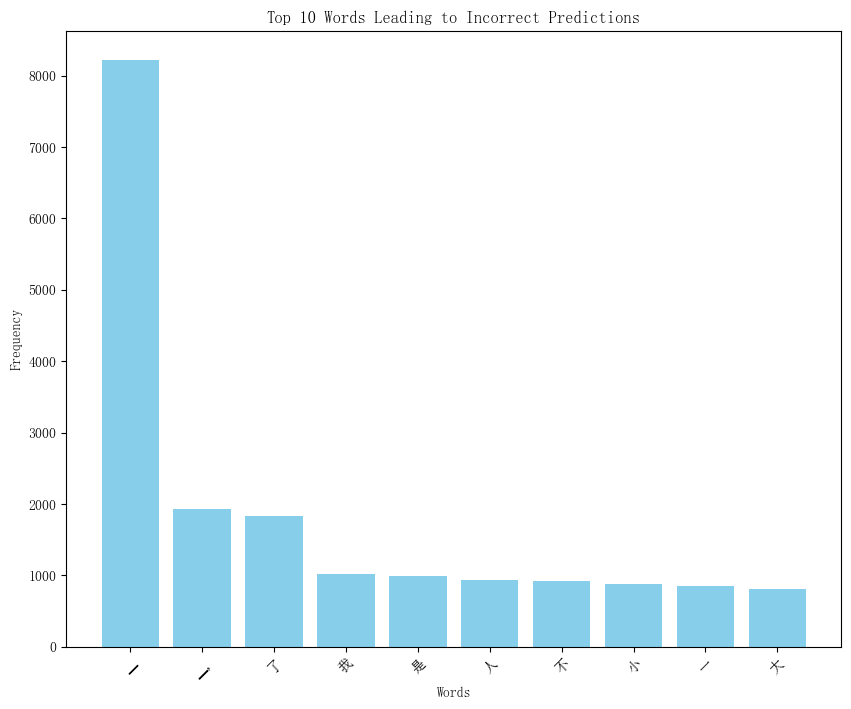

In [13]:
from collections import Counter
import matplotlib.pyplot as plt

# Assuming incorrect_texts is a list of strings where each string is an incorrectly predicted text

# Step 1: Tokenize the incorrect texts and flatten the list of lists into a single list of words
words_in_incorrect_texts = [word for text in incorrect_texts for word in text.split()]

# Step 2: Count the frequency of each word
word_counts = Counter(words_in_incorrect_texts)

# Step 3: Identify and rank the most frequent words
most_common_words = word_counts.most_common(10)  # Get the top 10
print(most_common_words[:])
# Step 4: Visualize the top 10 words
words, frequencies = zip(*most_common_words)  # Unzip the words and frequencies
plt.rcParams['font.family'] = 'SimSun'
plt.rcParams['axes.unicode_minus'] = False

# When creating the plot, specify the font properties for text elements
plt.figure(figsize=(10, 8))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words Leading to Incorrect Predictions')
plt.xticks(rotation=45)
plt.show()

In [14]:
'''model_1 = LogisticRegression(C=0.01, penalty = 'l1', solver = 'saga') #c=0.01

model_1.fit(X_train, y_train)
# Evaluate the model
model_1_predictions = model_1.predict(X_test)
print("Accuracy:", accuracy_score(y_test, model_1_predictions))
print(classification_report(y_test, model_1_predictions))

SyntaxError: incomplete input (2939295078.py, line 1)

In [ ]:
'''model_1 = LogisticRegression(C=0.1, penalty = 'l1', solver = 'saga')#c=0.1

model_1.fit(X_train, y_train)
# Evaluate the model
model_1_predictions = model_1.predict(X_test)
print("Accuracy:", accuracy_score(y_test, model_1_predictions))
print(classification_report(y_test, model_1_predictions))'''

In [ ]:
model_1 = LogisticRegression(C=1, penalty = 'l2', solver = 'saga') #c=1

model_1.fit(X_train, y_train)
# Evaluate the model
model_1_predictions = model_1.predict(X_test)
print("Accuracy:", accuracy_score(y_test, model_1_predictions))
print(classification_report(y_test, model_1_predictions))

In [ ]:
model_1 = LogisticRegression(C=1, penalty = 'l1', solver = 'liblinear') #c=1

model_1.fit(X_train, y_train)
# Evaluate the model
model_1_predictions = model_1.predict(X_test)
print("Accuracy:", accuracy_score(y_test, model_1_predictions))
print(classification_report(y_test, model_1_predictions))

In [ ]:
logistic_regression_model = LogisticRegression()

'''param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']  # solvers that support l1 penalty
}

print("gridsearch")
# Setup the grid search
grid_search = GridSearchCV(logistic_regression_model, param_grid, cv=5, scoring='accuracy')

print("fit")
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)'''

In [ ]:
logistic_regression_model.fit(X_train, y_train)

y_pred = logistic_regression_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))

In [ ]:
'''incorrect_texts = []
correct_texts = []
incorrect_predictions = []
correct_labels = []

for i in range(len(y_test)):
    if y_pred[i] != y_test[i]:
        incorrect_texts.append(joined_test_texts[i])
        incorrect_predictions.append(y_pred[i])
        correct_labels.append(y_test[i])
    else:
        correct_texts.append(joined_test_texts[i])

average_incorrect_length = []
sum_incorrect_length = 0
for j in range(len(incorrect_texts)):
    sum_incorrect_length = sum_incorrect_length + len(incorrect_texts[j])

average_incorrect_length = sum_incorrect_length/j

average_correct_length = []
sum_correct_length = 0
for h in range(len(correct_texts)):
    sum_correct_length = sum_correct_length + len(correct_texts[h])

average_correct_length = sum_correct_length/h

print(f"Average correct length: {average_correct_length}")
print(f"Average incorrect length: {average_incorrect_length}")
print(incorrect_texts[5])
print(len(incorrect_texts[5]))'''

In [ ]:
'''sgd_classifier = SGDClassifier(loss='hinge',  # Use 'hinge' for linear SVM, 'log' for logistic regression
                               max_iter=1000,
                               tol=1e-3,
                               random_state=42)
sgd_classifier.fit(X_train, y_train)

y_pred = sgd_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))'''

In [ ]:
'''svm_classifier = SVC(kernel='linear') 
svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))'''

'''linear_svc_model = LinearSVC(max_iter=1000) 
linear_svc_model.fit(X_train, y_train)
y_pred = linear_svc_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))'''

## Naive Bayes

In [ ]:
'''naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train, y_train)
y_pred_NB = naive_bayes_model.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_NB))

print(classification_report(y_test, y_pred_NB))
'''

## Random Forest

In [ ]:
'''random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)  
random_forest_model.fit(X_train, y_train)
y_pred_RF = random_forest_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))'''

## SGDClassifier

In [ ]:
#sgd_classifier = SGDClassifier(alpha = 0.0001, loss = 'log_loss', learning_rate = 'optimal', random_state=42, penalty = 'l2')
sgd_classifier = SGDClassifier()

sgd_classifier.fit(X_train, y_train)
y_pred = sgd_classifier.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Hyperparameter searching